In [43]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn import preprocessing

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Product Gallery.csv")

## ЧАСТЬ 1: препроцессинг

In [3]:
df.head()

,Address,CategoryID,Category,City,Customer Company,Shippers Company,Customer,Country,EmployeeID,Fax,...,Quantity,QuantityPerUnit,UnitCost,UnitPrice,UnitPrice (Products),UnitsInStock,UnitsOnOrder,Sales,Profit,City and Counry
0,Berliner Platz 43,2,Овощи,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Австрия,8,089-0877451,...,25,30,"8,96","12,03","11,8",14,0,"300,75","76,75","Мюнхен, Австрия"
1,Berliner Platz 43,3,Кондитерские изделия,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Англия,8,089-0877451,...,24,1,"26,13","33,55","31,23",15,0,"805,2","178,08","Мюнхен, Англия"
2,Berliner Platz 43,5,Мясо/Птица,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Аргентина,8,089-0877451,...,40,100,"7,43",9,9,61,0,360,"62,8","Мюнхен, Аргентина"
3,Berliner Platz 43,8,Приправы,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Бельгия,8,089-0877451,...,20,20,"6,45","7,99",8,112,0,"159,8","30,8","Мюнхен, Бельгия"
4,Berliner Platz 43,8,Приправы,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Бразилия,8,089-0877451,...,28,21,"3,43","3,9",4,11,50,"109,2","13,16","Мюнхен, Бразилия"


In [4]:
df.shape

(2172, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Address               2172 non-null   object
 1   CategoryID            2172 non-null   int64 
 2   Category              2172 non-null   object
 3   City                  2172 non-null   object
 4   Customer Company      2172 non-null   object
 5   Shippers Company      2172 non-null   object
 6   Customer              2172 non-null   object
 7   Country               2172 non-null   object
 8   EmployeeID            2172 non-null   int64 
 9   Fax                   1619 non-null   object
 10  OrderDate             2172 non-null   object
 11  OrderID               2172 non-null   int64 
 12  Phone                 2172 non-null   object
 13  PostalCode            2172 non-null   object
 14  ProductID             2172 non-null   int64 
 15  Product               2172 non-null   

Некоторые признаки не прочитались как числовые. Поэтому приведем их явно

In [6]:
for c in df.columns:
    if df[c].dtype == 'object':
        try:
            df[c] = df[c].str.replace(',','.').astype(float)
        except:
            pass

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Address               2172 non-null   object 
 1   CategoryID            2172 non-null   int64  
 2   Category              2172 non-null   object 
 3   City                  2172 non-null   object 
 4   Customer Company      2172 non-null   object 
 5   Shippers Company      2172 non-null   object 
 6   Customer              2172 non-null   object 
 7   Country               2172 non-null   object 
 8   EmployeeID            2172 non-null   int64  
 9   Fax                   1619 non-null   object 
 10  OrderDate             2172 non-null   object 
 11  OrderID               2172 non-null   int64  
 12  Phone                 2172 non-null   object 
 13  PostalCode            2172 non-null   object 
 14  ProductID             2172 non-null   int64  
 15  Product              

Проверим пропуски

In [8]:
df.isnull().any()

Address                 False
CategoryID              False
Category                False
City                    False
Customer Company        False
Shippers Company        False
Customer                False
Country                 False
EmployeeID              False
Fax                      True
OrderDate               False
OrderID                 False
Phone                   False
PostalCode              False
ProductID               False
Product                 False
ShipperID               False
StateProvince            True
SupplierID              False
Discount                False
Freight                 False
Quantity                False
QuantityPerUnit         False
UnitCost                False
UnitPrice               False
UnitPrice (Products)    False
UnitsInStock            False
UnitsOnOrder            False
Sales                   False
Profit                  False
City and Counry         False
dtype: bool

Есть пропуски по Fax и StateProvince, выведем их

In [9]:
print(f'Пропуски Fax: {df.Fax.isnull().sum()/df.shape[0]}')
print(f'Пропуски StateProvince: {df.StateProvince.isnull().sum()/df.shape[0]}')

Пропуски Fax: 0.2546040515653775
Пропуски StateProvince: 0.8370165745856354


Исходя из этого - можно удалить признаки, так как из Fax можно сделать лишь бинарный признак (есть/нет), а StateProvince имеет много пропусков.

In [10]:
df.drop(columns=['Fax','StateProvince'], inplace=True)

Построим тепловую коррялионную карту.

In [29]:
def plot_heatmap(df):
    correlation_matrix = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

<ipython-input-11-8808efba1f22>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


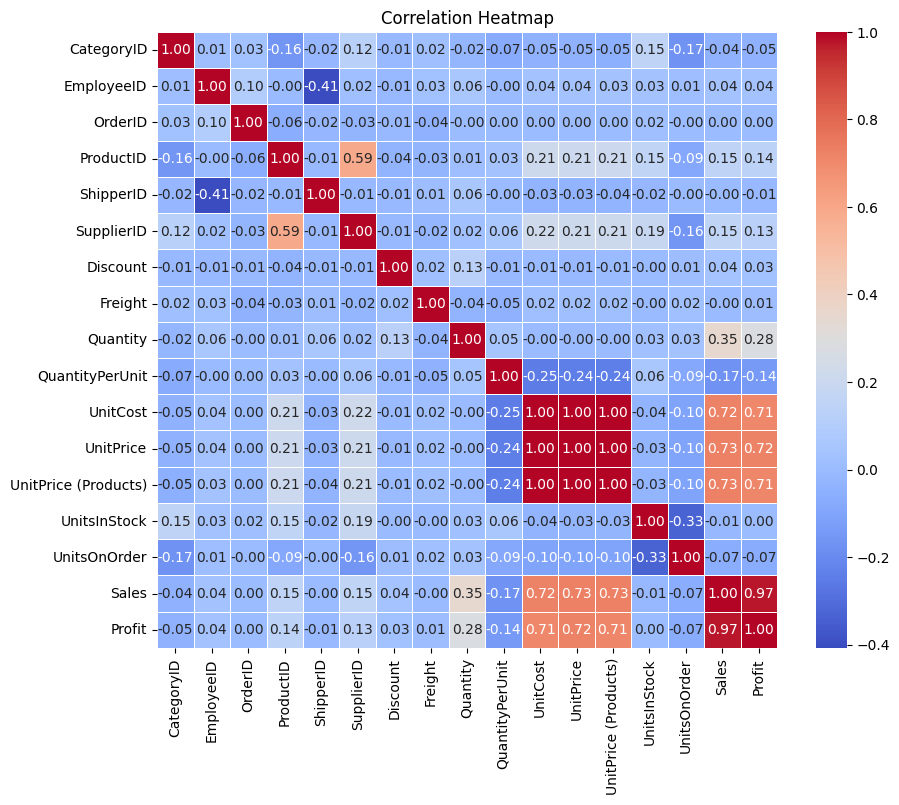

In [11]:
plot_heatmap(df)

Видно три переменные (UnitCost, UnitPrice, UnitPrice (Products)), которые линейно зависимы друг от друга. Можно оставить одну из них, которая сильнее связана с таргетом Profit - UnitPrice. Также удалим Sales. Так как почти линейно зависим с таргетом (0.97 корреляция).

In [12]:
df.drop(columns=['UnitCost','UnitPrice (Products)','Sales'], inplace=True)

Теперь закодируем признаки типа object (если это будет выгодно, и получатся объемные кластеры)

In [13]:
df.select_dtypes(include='object')

,Address,Category,City,Customer Company,Shippers Company,Customer,Country,OrderDate,Phone,PostalCode,Product,City and Counry
0,Berliner Platz 43,Овощи,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Австрия,20.11.2003,089-0877310,80805,Перец болгарский,"Мюнхен, Австрия"
1,Berliner Platz 43,Кондитерские изделия,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Англия,20.11.2003,089-0877310,80805,Пирожное Восточное,"Мюнхен, Англия"
2,Berliner Platz 43,Мясо/Птица,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Аргентина,20.11.2003,089-0877310,80805,Индейка,"Мюнхен, Аргентина"
3,Berliner Platz 43,Приправы,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Бельгия,20.11.2003,089-0877310,80805,Тмин,"Мюнхен, Бельгия"
4,Berliner Platz 43,Приправы,Мюнхен,Мюнхенские традиции,ТрансАвтоГруз,Dieter K?ln,Бразилия,20.11.2003,089-0877310,80805,Хмели-Сунели,"Мюнхен, Бразилия"
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,1900 Oak St.,Кондитерские изделия,Ванкувер,Милелниум,АвтоЛогистика,Joe Barry,Канада,30.07.2007,(604) 555-3392,V3F 2K1,Пирожное Медовик,"Ванкувер, Канада"
2168,1900 Oak St.,Приправы,Ванкувер,Милелниум,АвтоЛогистика,Joe Barry,Канада,30.07.2007,(604) 555-3392,V3F 2K1,Корица,"Ванкувер, Канада"
2169,35 King George,Овощи,Лондон,Продуктовый магазин,ТрансАвтоГруз,Greg Thatcher,Англия,30.07.2007,(171) 555-0297,WX1 6LT,Перец чили,"Лондон, Англия"
2170,35 King George,Мясо/Птица,Лондон,Продуктовый магазин,ТрансАвтоГруз,Greg Thatcher,Англия,30.07.2007,(171) 555-0297,WX1 6LT,Свинина,"Лондон, Англия"


Здесь мы можем убрать: City and Counry, Phone, Customer. Они не несут информации для таргета.

In [14]:
df.drop(columns=['City and Counry','Phone','Customer'], inplace=True)

In [15]:
for c in df.select_dtypes(include='object'):
    print(f'{c}: {round(len(df[c].unique())/df.shape[0],5)}')

Address: 0.04144
Category: 0.00368
City: 0.03223
Customer Company: 0.04098
Shippers Company: 0.00138
Country: 0.00967
OrderDate: 0.2523
PostalCode: 0.03775
Product: 0.03545


Видно что все дает большой кластер. Кроме OrderDate, но его можно распарсить на год и месяц, как минимум.

In [16]:
df['OrderYear'] = df['OrderDate'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').year)
df['OrderMonth'] = df['OrderDate'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').month)

In [17]:
df.drop(columns=['OrderDate'], inplace=True)

Закодируем теперь остальные признаки типа object

In [20]:
le = preprocessing.LabelEncoder()

In [23]:
for c in df.select_dtypes(include='object').columns:
    df[c] = le.fit_transform(df[c])

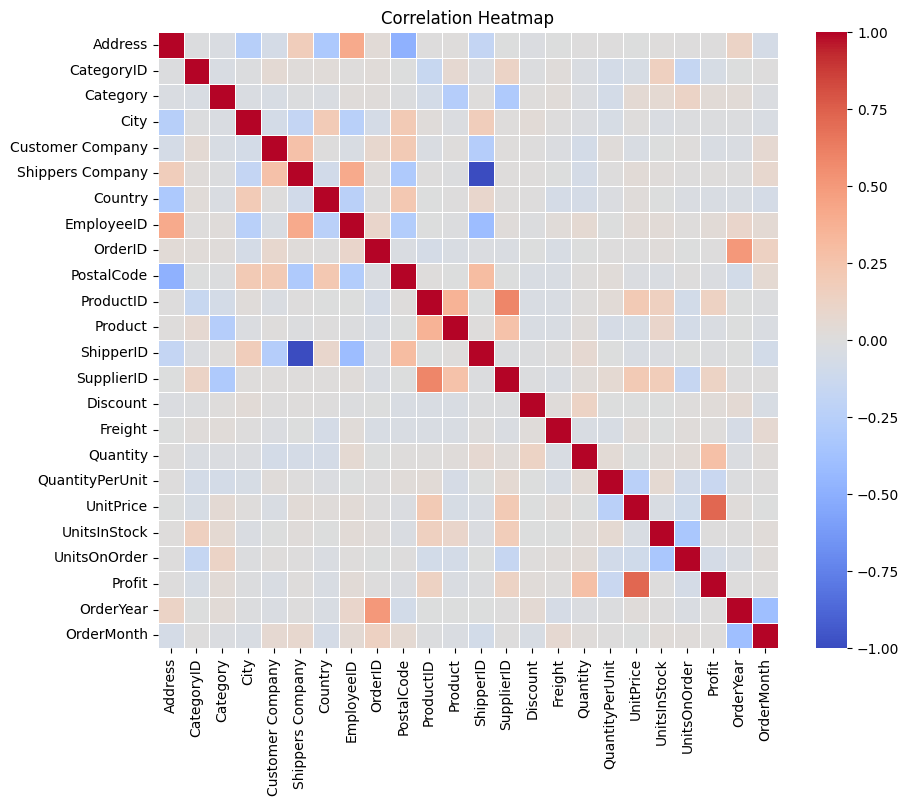

In [30]:
plot_heatmap(df)

У нас есть прищнаки, которые уже закодированы, уберем их. Так же уберем OrderID, Address

In [34]:
columns_to_delete = ['Shippers Company','Category','Product','OrderID','Address']
df.drop(columns=columns_to_delete, inplace=True)

## ЧАСТЬ 2: обучение моделей

In [44]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.4 MB/s eta 0:00:00


In [45]:
!pip install autogluon --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 5.7 MB/s eta 0:0

In [46]:
!pip install pycaret --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.9 MB/s eta 0:0

In [47]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from autogluon.tabular import TabularDataset, TabularPredictor
from pycaret.regression import *

In [48]:
X = df.drop('Profit', axis=1)
y = df['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest (Случайный лес

In [49]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared:", rf_r2)

Random Forest Mean Squared Error: 16624.674153001135
Random Forest R-squared: 0.9228829500116958


LightGBM

In [50]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)
print("LightGBM Mean Squared Error:", lgb_mse)
print("LightGBM R-squared:", lgb_r2)

LightGBM Mean Squared Error: 60393.75781380868
LightGBM R-squared: 0.7198508435446083


XGBoost

In [51]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared:", xgb_r2)

XGBoost Mean Squared Error: 15382.402270426264
XGBoost R-squared: 0.9286454895950835


CatBoost

In [ ]:
catboost_model = CatBoostRegressor()
catboost_model.fit(X_train, y_train)
catboost_predictions = catboost_model.predict(X_test)
catboost_mse = mean_squared_error(y_test, catboost_predictions)
catboost_r2 = r2_score(y_test, catboost_predictions)

In [53]:
print("CatBoost Mean Squared Error:", catboost_mse)
print("CatBoost R-squared:", catboost_r2)

CatBoost Mean Squared Error: 29977.308324319205
CatBoost R-squared: 0.8609439461317799


AutoGluon

In [ ]:
train_data = TabularDataset(df)
label = 'Profit'
predictor = TabularPredictor(label=label)
predictor.fit(train_data)
test_data = TabularDataset(X_test)
auto_gluon_predictions = predictor.predict(test_data)

In [55]:
auto_gluon_mse = mean_squared_error(y_test, auto_gluon_predictions)
auto_gluon_r2 = r2_score(y_test, auto_gluon_predictions)

In [56]:
print("AutoGluon Mean Squared Error:", auto_gluon_mse)
print("AutoGluon R-squared:", auto_gluon_r2)

AutoGluon Mean Squared Error: 517.9515077876587
AutoGluon R-squared: 0.9975973729199157


PyCaret

In [ ]:
exp_reg = setup(data=df, target='Profit', session_id=42)
best_model = compare_models()
predictions = predict_model(best_model, data=X_test)

In [62]:
pycaret_mse = mean_squared_error(y_test, predictions['prediction_label'])
pycaret_r2 = r2_score(y_test, predictions['prediction_label'])

In [63]:
print("PyCaret Mean Squared Error:", pycaret_mse)
print("PyCaret R-squared:", pycaret_r2)

PyCaret Mean Squared Error: 10716.428655488164
PyCaret R-squared: 0.95028959023704


Сравнение моделей

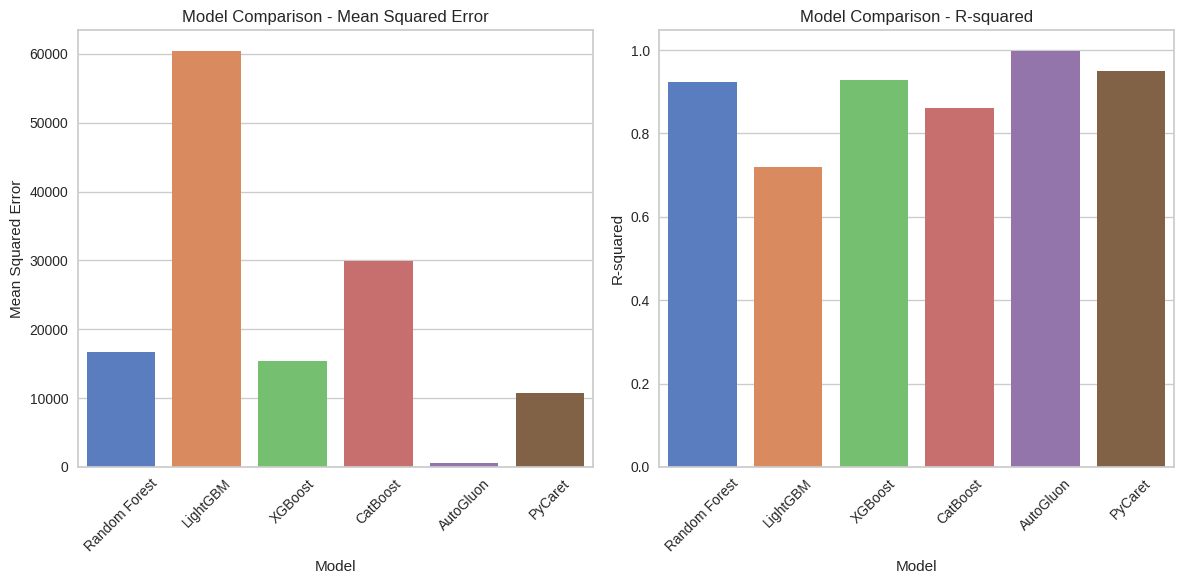

In [64]:
mse_r2_df = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'AutoGluon', 'PyCaret'],
    'Mean Squared Error': [rf_mse, lgb_mse, xgb_mse, catboost_mse, auto_gluon_mse, pycaret_mse],
    'R-squared': [rf_r2, lgb_r2, xgb_r2, catboost_r2, auto_gluon_r2, pycaret_r2]
})

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Mean Squared Error', data=mse_r2_df, palette='muted')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison - Mean Squared Error')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R-squared', data=mse_r2_df, palette='muted')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Model Comparison - R-squared')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Лучше всего предсказывает таргет модель AutoGluon, так как она дает наименьший показатель MSE и наивысший показатель R-squared